**Sumário**<a id='toc0_'></a>    
- [Avaliação dos modelos](#toc1_)    
  - [Árvore de decisão](#toc1_1_)    
  - [XGBoost](#toc1_2_)    
  - [SVM](#toc1_3_)    
  - [Rede neural](#toc1_4_)    
  - [Floresta aleatória](#toc1_5_)    
  - [KNN](#toc1_6_)    
- [Resultados gerais](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Avaliação dos modelos](#toc0_)

In [15]:
from sklearnex import patch_sklearn   # noreorder

patch_sklearn()

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from time import time
import matplotlib.pyplot as plt

plt.style.use('../tcc.mplstyle')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
DATASET_PATH = Path('D:/dados_tcc/dataset')
SAVE_PATH = Path('D:/dados_tcc/files')
FIG_PATH = Path('G:/Meu Drive/TCC/TCC Texto/Figuras')

r2, mse, mae, train_time = {}, {}, {}, {}

X = pd.read_feather(DATASET_PATH / 'X_clean.feather', columns=[0, 11, 15, 20])
y = np.load(DATASET_PATH / 'y_clean.npy')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [3]:
# https://stackoverflow.com/a/65467569
class ScalerSelector(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, X, y=None):
        return self.scaler.fit(X)

    def transform(self, X, y=None):
        return self.scaler.transform(X)


# https://stackoverflow.com/a/49683957
def scatterplot(y_true, y_pred, save=False, label=None, save_path=None):
    # 2d histogram
    hh, locx, locy = np.histogram2d(y_true, y_pred, bins=[50, 50])

    # sorting the points by density
    z = np.array(
        [
            hh[np.argmax(a <= locx[1:]), np.argmax(b <= locy[1:])]
            for a, b in zip(y_true, y_pred)
        ]
    )
    idx = z.argsort()
    y_true, y_pred, density = y_true[idx], y_pred[idx], z[idx]

    plt.plot(
        [-0.5, 12],
        [-0.5, 12],
        'r--',
        linewidth=2,
        alpha=0.5,
        label=r'$R^2=1$',
        zorder=0,
    )
    plt.scatter(y_true, y_pred, c=density, rasterized=True)
    plt.colorbar(label='Quantidade de pontos')

    plt.xlabel(r'$\theta(t)$')
    plt.ylabel(r'$\hat{\theta}(t)$')
    plt.legend()
    plt.tight_layout()

    plt.xlim((-0.5, 10.5))

    if save:
        plt.savefig(save_path / f'{label}_scatter.pdf', dpi=300)

    plt.show()


## <a id='toc1_1_'></a>[Árvore de decisão](#toc0_)

In [12]:
with open(SAVE_PATH / 'hyperparameter_tree.joblib', 'rb') as file:
    tree_params = joblib.load(file)

tree_params = tree_params.best_params_

In [13]:
label = 'tree'

tree_pipeline = Pipeline(
    steps=[
        ('scaler_selector', ScalerSelector()),
        ('tree', DecisionTreeRegressor(random_state=123)),
    ]
)

tree_pipeline.set_params(**tree_params)

# fitting
initial_time = time()
tree_pipeline.fit(X_train, y_train)
final_time = time()

# predicting
y_pred = tree_pipeline.predict(X_test)

# metrics
r2[label] = r2_score(y_test, y_pred)
mse[label] = mean_squared_error(y_test, y_pred)
mae[label] = mean_absolute_error(y_test, y_pred)
train_time[label] = final_time - initial_time

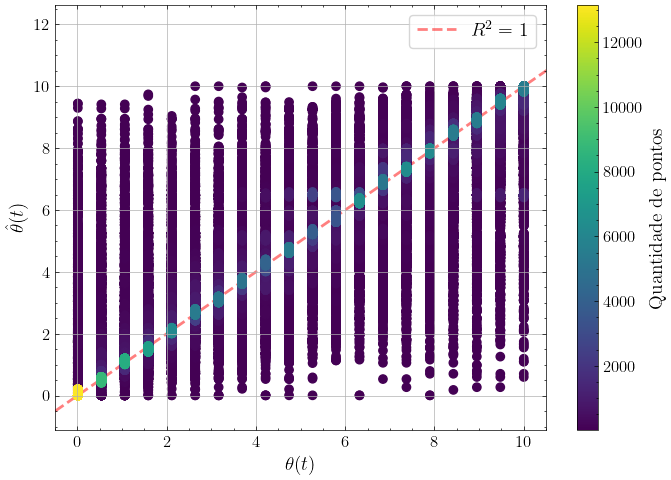

In [14]:
scatterplot(y_test, y_pred, save=True, label=label, save_path=FIG_PATH)

## <a id='toc1_2_'></a>[XGBoost](#toc0_)

In [15]:
with open(SAVE_PATH / 'hyperparameter_xgb.joblib', 'rb') as file:
    _, xgb_params = joblib.load(file)

xgb_params

{'scaler': StandardScaler(),
 'booster': 'gbtree',
 'max_depth': 13,
 'n_estimators': 150}

In [4]:
label = 'xgb'

xgb_pipeline = Pipeline(
    steps=[
        ('scaler_selector', ScalerSelector()),
        (
            'xgb',
            XGBRegressor(
                booster='gbtree',
                max_depth=13,
                n_estimators=150,
                random_state=123,
            ),
        ),
    ]
)

xgb_pipeline.set_params(**{'scaler_selector__scaler': StandardScaler()})

# fitting
initial_time = time()
xgb_pipeline.fit(X_train, y_train)
final_time = time()

# saving the model
with open(SAVE_PATH / 'xgb.joblib', 'wb') as file:
    joblib.dump(xgb_pipeline)

# predicting
y_pred = xgb_pipeline.predict(X_test)

# metrics
r2[label] = r2_score(y_test, y_pred)
mse[label] = mean_squared_error(y_test, y_pred)
mae[label] = mean_absolute_error(y_test, y_pred)
train_time[label] = final_time - initial_time

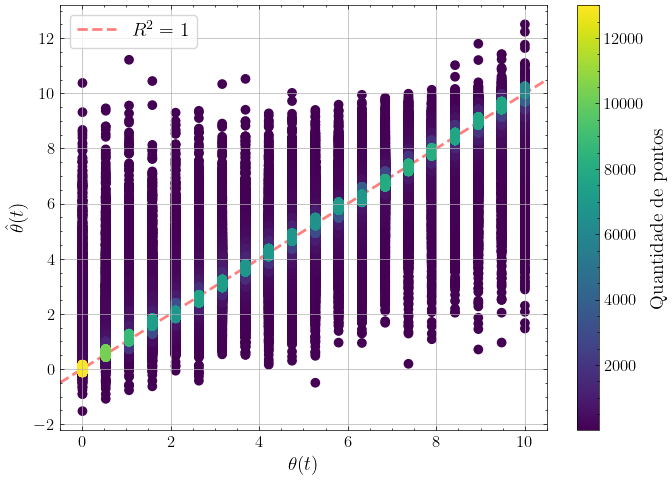

In [17]:
scatterplot(y_test, y_pred, save=True, label=label, save_path=FIG_PATH)

## <a id='toc1_3_'></a>[SVM](#toc0_)

In [18]:
with open(SAVE_PATH / 'hyperparameter_svm.joblib', 'rb') as file:
    svm_params = joblib.load(file)

svm_params = svm_params.best_params_

In [19]:
label = 'svm'

svm_pipeline = Pipeline(
    steps=[
        ('scaler_selector', ScalerSelector()),
        (
            'svm',
            LinearSVR(
                random_state=123,
                dual=False,
                loss='squared_epsilon_insensitive',
            ),
        ),
    ]
)

svm_pipeline.set_params(**svm_params)

# fitting
initial_time = time()
svm_pipeline.fit(X_train, y_train)
final_time = time()

# predicting
y_pred = svm_pipeline.predict(X_test)

# saving the model
with open(SAVE_PATH / 'svm.joblib', 'wb') as file:
    joblib.dump(svm_pipeline, file)

# metrics
r2[label] = r2_score(y_test, y_pred)
mse[label] = mean_squared_error(y_test, y_pred)
mae[label] = mean_absolute_error(y_test, y_pred)
train_time[label] = final_time - initial_time

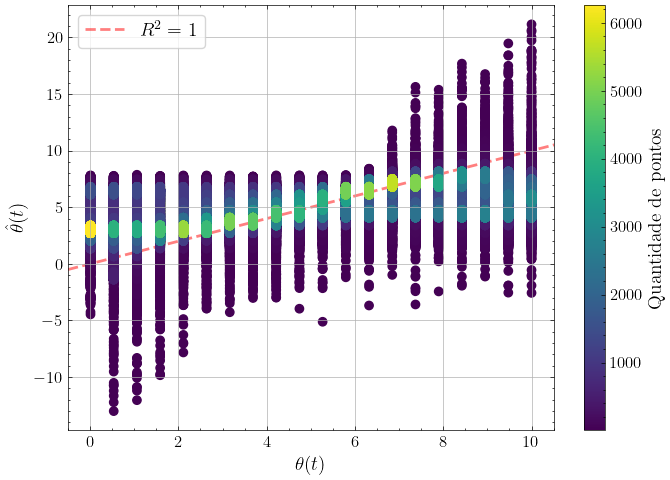

In [20]:
scatterplot(y_test, y_pred, save=True, label=label, save_path=FIG_PATH)

## <a id='toc1_4_'></a>[Rede neural](#toc0_)

In [21]:
with open(SAVE_PATH / 'hyperparameter_nn.joblib', 'rb') as file:
    nn_params = joblib.load(file)

nn_params = nn_params.best_params_

In [22]:
label = 'nn'

nn_pipeline = Pipeline(
    steps=[
        ('scaler_selector', ScalerSelector()),
        (
            'nn',
            MLPRegressor(
                random_state=123,
                early_stopping=True,
                verbose=True,
                n_iter_no_change=6,
                max_iter=300,
            ),
        ),
    ]
)

nn_pipeline.set_params(**nn_params)

# fitting
initial_time = time()
nn_pipeline.fit(X_train, y_train)
final_time = time()

# predicting
y_pred = nn_pipeline.predict(X_test)

# saving the model
with open(SAVE_PATH / 'nn.joblib', 'wb') as file:
    joblib.dump(nn_pipeline, file)

# metrics
r2[label] = r2_score(y_test, y_pred)
mse[label] = mean_squared_error(y_test, y_pred)
mae[label] = mean_absolute_error(y_test, y_pred)
train_time[label] = final_time - initial_time

Iteration 1, loss = 1.26411682
Validation score: 0.848778
Iteration 2, loss = 0.65271854
Validation score: 0.870854
Iteration 3, loss = 0.58557328
Validation score: 0.876704
Iteration 4, loss = 0.56637218
Validation score: 0.880586
Iteration 5, loss = 0.55464644
Validation score: 0.883067
Iteration 6, loss = 0.54705953
Validation score: 0.884692
Iteration 7, loss = 0.54140565
Validation score: 0.884681
Iteration 8, loss = 0.53636484
Validation score: 0.887937
Iteration 9, loss = 0.53229160
Validation score: 0.888773
Iteration 10, loss = 0.52955428
Validation score: 0.888070
Iteration 11, loss = 0.52684679
Validation score: 0.890183
Iteration 12, loss = 0.52385262
Validation score: 0.887843
Iteration 13, loss = 0.52156751
Validation score: 0.885726
Iteration 14, loss = 0.51972959
Validation score: 0.888100
Iteration 15, loss = 0.51784822
Validation score: 0.890543
Iteration 16, loss = 0.51595414
Validation score: 0.891796
Iteration 17, loss = 0.51356520
Validation score: 0.891797
Iterat

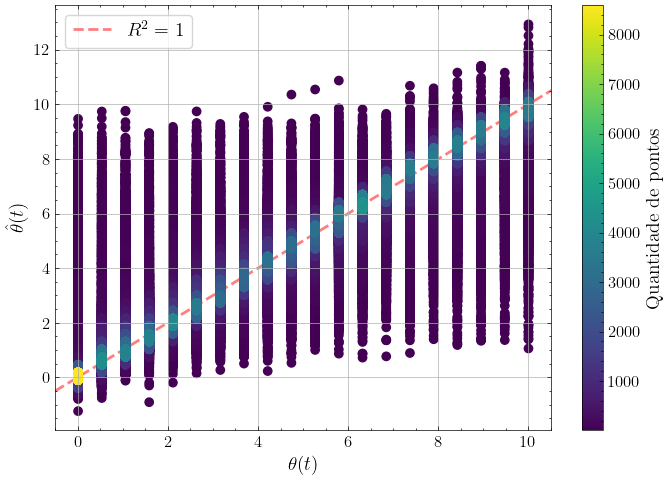

In [23]:
scatterplot(y_test, y_pred, save=True, label=label, save_path=FIG_PATH)

## <a id='toc1_5_'></a>[Floresta aleatória](#toc0_)

In [24]:
with open(SAVE_PATH / 'hyperparameter_rf.joblib', 'rb') as file:
    rf_params = joblib.load(file)

rf_params = rf_params.best_params_

In [25]:
label = 'rf'

rf_pipeline = Pipeline(
    steps=[
        ('scaler_selector', ScalerSelector()),
        ('rf', RandomForestRegressor(random_state=123)),
    ]
)

rf_pipeline.set_params(**rf_params)

# fitting
initial_time = time()
rf_pipeline.fit(X_train, y_train)
final_time = time()

# predicting
y_pred = rf_pipeline.predict(X_test)

# saving the model
with open(SAVE_PATH / 'rf.joblib', 'wb') as file:
    joblib.dump(rf_pipeline, file)

# metrics
r2[label] = r2_score(y_test, y_pred)
mse[label] = mean_squared_error(y_test, y_pred)
mae[label] = mean_absolute_error(y_test, y_pred)
train_time[label] = final_time - initial_time

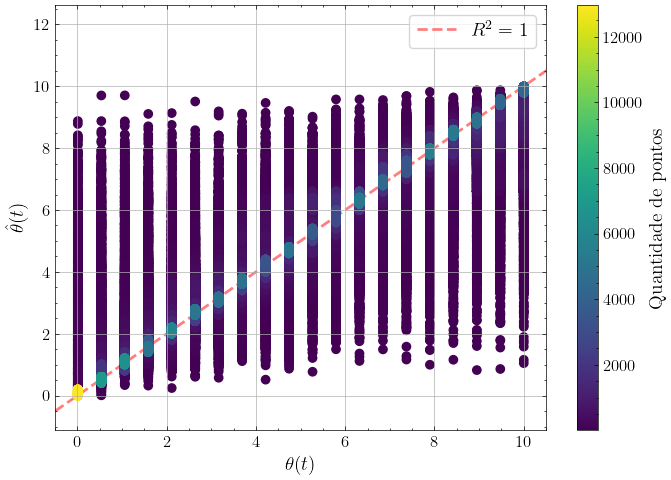

In [26]:
scatterplot(y_test, y_pred, save=True, label=label, save_path=FIG_PATH)

## <a id='toc1_6_'></a>[KNN](#toc0_)

In [13]:
with open(SAVE_PATH / 'hyperparameter_knn.joblib', 'rb') as file:
    knn_params = joblib.load(file)

knn_params = knn_params.best_params_

In [14]:
label = 'knn'

knn_pipeline = Pipeline(
    steps=[
        ('scaler_selector', ScalerSelector()),
        ('knn', KNeighborsRegressor()),
    ]
)

knn_pipeline.set_params(**knn_params)

# fitting
initial_time = time()
knn_pipeline.fit(X_train, y_train)
final_time = time()

# predicting
y_pred = knn_pipeline.predict(X_test)

# saving the model
with open(SAVE_PATH / 'knn.joblib', 'wb') as file:
    joblib.dump(knn_pipeline, file)

# metrics
r2[label] = r2_score(y_test, y_pred)
mse[label] = mean_squared_error(y_test, y_pred)
mae[label] = mean_absolute_error(y_test, y_pred)
train_time[label] = final_time - initial_time

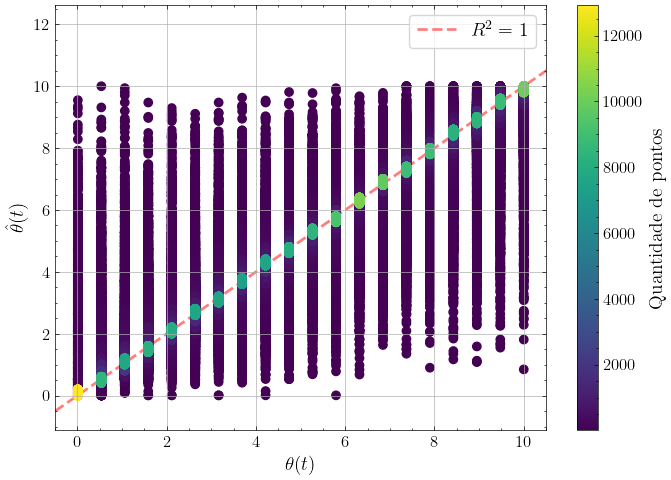

In [29]:
scatterplot(y_test, y_pred, save=True, label=label, save_path=FIG_PATH)

# <a id='toc2_'></a>[Resultados gerais](#toc0_)

In [30]:
results = pd.DataFrame((r2, mse, mae, train_time)).T
results.columns = ['r2', 'mse', 'mae', 'train_time']
results = results.sort_values('r2', ascending=False)

In [31]:
results

,r2,mse,mae,train_time
xgb,0.943779,0.519404,0.328684,23.257298
knn,0.934013,0.609625,0.317705,2.245927
rf,0.899886,0.924910,0.521553,42.476433
nn,0.894206,0.977385,0.569232,146.078952
tree,0.891632,1.001167,0.513611,12.634509
svm,0.342157,6.077514,1.877500,0.578000
